In [1]:
import pandas
import matplotlib
import seaborn
import lifelines
import sys

sys.path.append('..')

from helpers import FIG_SIZE
from helpers import savefig as _savefig

In [2]:
%matplotlib inline

PALETTE_BASE = seaborn.color_palette('Paired', n_colors=12)
PALETTE = PALETTE_BASE[1::2]

PAL_DEP = PALETTE_BASE[:2][::-1]
PAL_REL = PALETTE_BASE[2:4][::-1]
PAL_PKG = PALETTE_BASE[4:6][::-1]
PAL_UPD = seaborn.color_palette('hls', 8)[0:3] + [seaborn.color_palette('hls', 8)[5]]
PAL_VAR = seaborn.color_palette()  # seaborn.hls_palette(l=0.5, s=0.9)[:3]

DATE_RANGE = pandas.to_datetime('2011-01-01'), pandas.to_datetime('2017-11-30')

CENSOR_DATE = pandas.to_datetime('2018-01-01')

matplotlib.rcParams['figure.figsize'] = FIG_SIZE

#savefig = lambda x, y: None # use _savefig to export figures
savefig = _savefig

In [3]:
df_lags = pandas.read_csv('../data/lags.csv')

In [4]:
df_lags = (
    df_lags
    .assign(
        Time=lambda d: pandas.to_datetime(d['Time'], infer_datetime_format=True),
        NextTime=lambda d: pandas.to_datetime(d['NextTime'], infer_datetime_format=True),
        TemporalLagAtTime=lambda d: pandas.to_timedelta(d['TemporalLagAtTime']),
        TemporalLagAtNextTime=lambda d: pandas.to_timedelta(d['TemporalLagAtNextTime']),
    )
    # Must be outside previous assign, because NextTime is not necessarily computed as datetime.
    .assign(Censored=lambda d: d['NextTime'] == CENSOR_DATE)
    
    # Identify if a new release was available and missed
    .assign(NewAvailable=lambda d: 
            (d['HighestInstallableAtTime'] != d['HighestInstallableAtNextTime']) 
            | (~d['HighestMissedAtNextTime'].isnull() & (d['HighestMissedAtTime'] != d['HighestMissedAtNextTime']))
    )
    .assign(NewMissed=lambda d: 
            d['NewAvailable'] & ~d['HighestMissedAtNextTime'].isnull()
    )
)

In [5]:
vlag_at_time = df_lags['VersionLagAtTime'].str.extract(r'\(([0-9]+), ([0-9]+), ([0-9]+)\)', expand=True)
vlag_at_next_time = df_lags['VersionLagAtNextTime'].str.extract(r'\(([0-9]+), ([0-9]+), ([0-9]+)\)', expand=True)

In [6]:
df_lags[['MLagAtTime', 'mLagAtTime', 'pLagAtTime']] = vlag_at_time.astype(int)
df_lags[['MLagAtNextTime', 'mLagAtNextTime', 'pLagAtNextTime']] = vlag_at_next_time.astype(int)

In [7]:
df_releases = (
    pandas.read_csv('../data/releases.csv.gz')
    .assign(ReleaseDate=lambda d: pandas.to_datetime(d['ReleaseDate'], infer_datetime_format=True))
    .assign(NextReleaseDateByDate=lambda d: pandas.to_datetime(d['NextReleaseDateByDate'], infer_datetime_format=True))
)

In [8]:
df_releases = (
    df_releases
    .assign(NextRankByDate=lambda d: d['RankByDate'] + 1)
    .merge(
        (
            df_releases
            [['Package', 'RankByDate', 'ReleaseType', 'ReleaseDate']]
            .rename(columns={
                'ReleaseDate': 'NextReleaseDate',
                'RankByDate': 'NextRankByDate', 
                'ReleaseType': 'NextReleaseType',
            })
        ),
        how='left', 
        on=['Package', 'NextRankByDate']
    )
    .assign(PreviousRankByDate=lambda d: d['RankByDate'] - 1)
    .merge(
        (
            df_releases
            [['Package', 'RankByDate', 'ReleaseType', 'ReleaseDate']]
            .rename(columns={
                'ReleaseDate': 'PreviousReleaseDate',
                'RankByDate': 'PreviousRankByDate', 
                'ReleaseType': 'PreviousReleaseType',
            })
        ),
        how='left', 
        on=['Package', 'PreviousRankByDate']
    )
)

# Overview

Filters:
 - We removed all "misc" updates (322840 out of 4202099)
 - Update in 2017
 - At least 2 releases
 
 
```
Load releases
.. 3878928 releases
Load dependencies
.. 20240402 dependencies
Filter packages
.. 182528 packages
Filter dependencies & join dates
.. 9474438 dependencies
Filter releases & set index
.. 2157333 releases

```

## Number of filtered packages, releases and dependencies

In [46]:
df_tmp = pandas.concat([
    # Time
    df_lags['Time'],
    
    # Count dependencies
    (
        df_lags
        .assign(NDependencies=1)
        ['NDependencies']
    ),
    
    # Count releases
    (
        df_lags
        .drop_duplicates(['Package', 'Release'], keep='first')
        .assign(NReleases=1)
        ['NReleases']
    ),
    
    # Count packages
    (
        df_lags
        .drop_duplicates('Package', keep='first')
        .assign(NPackages=1)
        ['NPackages']
    )
], axis=1).fillna({'NReleases': 0, 'NPackages': 0})

df_tmp[['NPackages', 'NReleases', 'NDependencies']].sum()

NPackages         120084.0
NReleases        1447709.0
NDependencies    8044034.0
dtype: float64

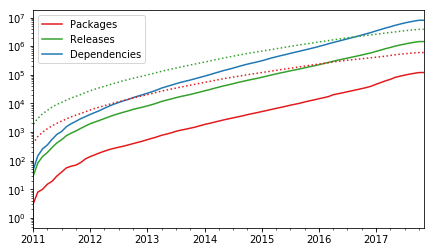

In [47]:
ax = (
    df_tmp
    .groupby(pandas.Grouper(freq='1M', key='Time'))
    .sum()
    .sort_index()
    .cumsum()
    .assign(**{
        'Dependencies': lambda d: d['NDependencies'],
        'Releases': lambda d: d['NReleases'], 
        'Packages': lambda d: d['NPackages'],
    })
    [['Packages', 'Releases', 'Dependencies']]
    .plot(color=PALETTE[0:3][::-1])
)

if True:
    (
        pandas.concat([
            df_releases['ReleaseDate'],
            df_releases.assign(Releases=1)['Releases'],
            df_releases.drop_duplicates('Package', keep='first').assign(Packages=1)['Packages']
        ], axis=1)
        .fillna({'Releases': 0, 'Packages': 0})
        .groupby(pandas.Grouper(freq='1M', key='ReleaseDate'))
        .sum()
        .sort_index()
        .cumsum()
        [['Packages', 'Releases']]
        .plot(legend=False, style=':', color=PALETTE[0:3][::-1], ax=ax)
    )

ax.set(
    xlabel='', 
    ylabel='',
    xlim=DATE_RANGE,
    yscale='log',
)

savefig(ax.figure, 'overview_nb_deps_rels_pkgs')

# Dots represent the original dataset

# Temporal lag

Aggregate time lag for releases

In [11]:
df_lags_releases = (
    df_lags
    .groupby(['Package', 'Release'])
    .agg({
        'Time': 'first',
        'NextTime': 'first',
        'Censored': 'first',
        
        'TemporalLagAtTime': 'max', 
        'TemporalLagAtNextTime': 'max',
        
        'NewAvailable': 'max', 
        'NewMissed': 'max',
        
        'MLagAtTime': 'max', 
        'mLagAtTime': 'max',
        'pLagAtTime': 'max',
        'MLagAtNextTime': 'max',
        'mLagAtNextTime': 'max',
        'pLagAtNextTime': 'max',
    })
    .reset_index()
    .merge(
        df_releases[['Package', 'Release', 'RankByVersion', 'RankByDate', 'ReleaseType']], 
        how='left', 
        on=('Package', 'Release')
    )
)

Get data from previous and next releases (using date)

In [12]:
df_lags_releases = (
    df_lags_releases
    .assign(NextRankByDate=lambda d: d['RankByDate'] + 1)
    .merge(
        (
            df_lags_releases
            [['Package', 'RankByDate', 'ReleaseType', 'TemporalLagAtTime', 
              'MLagAtTime', 'mLagAtTime', 'pLagAtTime']]
            .rename(columns={
                'RankByDate': 'NextRankByDate', 
                'ReleaseType': 'NextReleaseType',
                'TemporalLagAtTime': 'NextTemporalLagAtTime',
                'MLagAtTime': 'NextMLagAtTime',
                'mLagAtTime': 'NextmLagAtTime',
                'pLagAtTime': 'NextpLagAtTime',
            })
        ),
        how='left', 
        on=['Package', 'NextRankByDate']
    )
    .assign(PreviousRankByDate=lambda d: d['RankByDate'] - 1)
    .merge(
        (
            df_lags_releases
            [['Package', 'RankByDate', 'Time', 'ReleaseType', 'TemporalLagAtTime', 'TemporalLagAtNextTime',
             'MLagAtTime', 'mLagAtTime', 'pLagAtTime', 'MLagAtNextTime', 'mLagAtNextTime', 'pLagAtNextTime']]
            .rename(columns={
                'RankByDate': 'PreviousRankByDate', 
                'Time': 'PreviousTime',
                'ReleaseType': 'PreviousReleaseType',
                'TemporalLagAtTime': 'PreviousTemporalLagAtTime',
                'TemporalLagAtNextTime': 'PreviousTemporalLagAtNextTime',
                'MLagAtTime': 'PreviousMLagAtTime',
                'mLagAtTime': 'PreviousmLagAtTime',
                'pLagAtTime': 'PreviouspLagAtTime',
                'MLagAtNextTime': 'PreviousMLagAtNextTime',
                'mLagAtNextTime': 'PreviousmLagAtNextTime',
                'pLagAtNextTime': 'PreviouspLagAtNextTime',
            })
        ),
        how='left', 
        on=['Package', 'PreviousRankByDate']
    )
)

## Proportion of releases and dependencies with lag at start/end

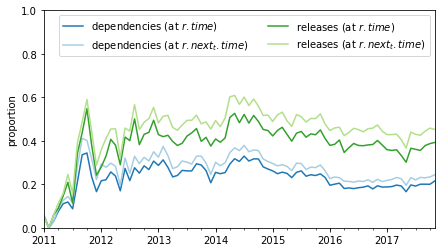

In [58]:
fig, ax = matplotlib.pyplot.subplots()

(
    df_lags
    .assign(n=1)
    .assign(lag_at_start=lambda d: (d['TemporalLagAtTime'] > pandas.to_timedelta('0D')).astype(int))
    .assign(lag_at_end=lambda d: (d['TemporalLagAtNextTime'] > pandas.to_timedelta('0D')).astype(int))
    [['NextTime', 'n', 'lag_at_start', 'lag_at_end']]
    .groupby(pandas.Grouper(key='NextTime', freq='1M'))
    .sum()
    .assign(lag_at_start=lambda d: d['lag_at_start'] / d['n'])
    .assign(lag_at_end=lambda d: d['lag_at_end'] / d['n'])
    [['lag_at_start', 'lag_at_end']]
    .rename(columns={
        'lag_at_start': 
        'dependencies (at $r.\\mathit{time}$)', 
        'lag_at_end': 'dependencies (at $r.\\mathit{next_t.time}$)'
    })
    .plot(ax=ax, color=PAL_DEP)
)

(
    df_lags_releases
    .assign(n=1)
    .assign(lag_at_start=lambda d: (d['TemporalLagAtTime'] > pandas.to_timedelta('0D')).astype(int))
    .assign(lag_at_end=lambda d: (d['TemporalLagAtNextTime'] > pandas.to_timedelta('0D')).astype(int))
    [['NextTime', 'n', 'lag_at_start', 'lag_at_end']]
    .groupby(pandas.Grouper(key='NextTime', freq='1M'))
    .sum()
    .assign(lag_at_start=lambda d: d['lag_at_start'] / d['n'])
    .assign(lag_at_end=lambda d: d['lag_at_end'] / d['n'])
    [['lag_at_start', 'lag_at_end']]
    .rename(columns={
        'lag_at_start': 'releases (at $r.\\mathit{time}$)', 
        'lag_at_end': 'releases (at $r.\\mathit{next_t.time}$)'
    })
    .plot(ax=ax, color=PAL_REL)
)

ax.set(
    xlabel='',
    ylabel='proportion',
    xlim=DATE_RANGE,
    ylim=(0, 1),
)
ax.legend(ncol=2)

savefig(fig, 'temporal_proportion_with_lag')

## Time lag distribution (at release end)

### For dependencies

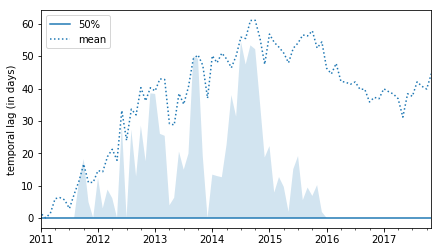

In [14]:
fig, ax = matplotlib.pyplot.subplots()

df_tmp = (
    df_lags
    [lambda d: ~d['Censored']]
    .groupby(pandas.Grouper(key='NextTime', freq='1M'))
    ['TemporalLagAtNextTime']
    .describe()
    [['mean', '25%', '50%', '75%']]
    .dropna()
    .apply(lambda s: s / pandas.np.timedelta64(1, 'D'), axis=1)
)

df_tmp['50%'].plot(color=PAL_DEP, ax=ax)
df_tmp['mean'].plot(color=PAL_DEP, style=':', ax=ax)
ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], facecolor=PAL_DEP[0], alpha=0.2)

ax.set(
    xlabel='',
    ylabel='temporal lag (in days)',
    xlim=DATE_RANGE,
)
ax.legend(loc='upper left')

savefig(fig, 'temporal_distr_deps_at_next_time')
# NOTE: Only packages being updated in given month are considered for that month.

There was a change in the way `npm install --save` works in February 2014: http://fredkschott.com/post/2014/02/npm-no-longer-defaults-to-tildes/
caret is used by default instead of tilde, meaning that by default, the constraints allow everything up to the next major, instead of everything up to the next minor. Constraints usage could perhaps highlight this change, and could perhaps explain the change in trend we observe in 2016?

In end 2015, `npm@3` has been released to replace `npm@2`. Among the changes, dependencies are now installed in "flat" mode (all dependencies in the same directory) instead of in "nested" mode. This could also have changed the way maintainers declare their dependencies. To avoid dependencies to be installed in "nested mode", the dependency constraints should be compatible with the dependency constraints of already installed packages, meaning implicitly that "soft" constraints are more likely to lead to "flat" installation, where "hard" constraints are more likely to lead to "nested" installation. Again, constraints usage analysis could give some insights on this.

### For dependencies (0 filtered)

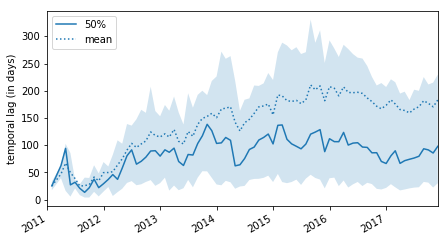

In [15]:
fig, ax = matplotlib.pyplot.subplots()

df_tmp = (
    df_lags
    [lambda d: ~d['Censored']]
    [lambda d: d['TemporalLagAtNextTime'] > pandas.to_timedelta('0D')]
    .groupby(pandas.Grouper(key='NextTime', freq='1M'))
    ['TemporalLagAtNextTime']
    .describe()
    [['mean', '25%', '50%', '75%']]
    .dropna()
    .apply(lambda s: s / pandas.np.timedelta64(1, 'D'), axis=1)
)

df_tmp['50%'].plot(color=PAL_DEP, ax=ax)
df_tmp['mean'].plot(color=PAL_DEP, style=':', ax=ax)
ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], facecolor=PAL_DEP[0], alpha=0.2)

ax.set(
    xlabel='',
    ylabel='temporal lag (in days)',
    xlim=DATE_RANGE,
)
ax.legend(loc='upper left')

savefig(fig, 'temporal_distr_deps_at_next_time_filtered')
# NOTE: Only packages being updated in given month are considered for that month.

### For releases

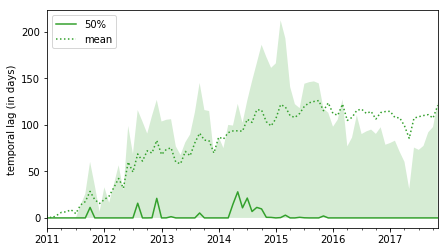

In [16]:
fig, ax = matplotlib.pyplot.subplots()

df_tmp = (
    df_lags_releases
    [lambda d: ~d['Censored']]
    .groupby(pandas.Grouper(key='NextTime', freq='1M'))
    ['TemporalLagAtNextTime']
    .describe()
    [['mean', '25%', '50%', '75%']]
    .dropna()
    .apply(lambda s: s / pandas.np.timedelta64(1, 'D'), axis=1)
)

df_tmp['50%'].plot(color=PAL_REL, ax=ax)
df_tmp['mean'].plot(color=PAL_REL, style=':', ax=ax)
ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], facecolor=PAL_REL[0], alpha=0.2)

ax.set(
    xlabel='',
    ylabel='temporal lag (in days)',
    xlim=DATE_RANGE,
)
ax.legend(loc='upper left')

savefig(fig, 'temporal_distr_releases_at_nexttime')
# NOTE: Only packages being updated in given month are considered for that month.

### For releases (0 filtered)

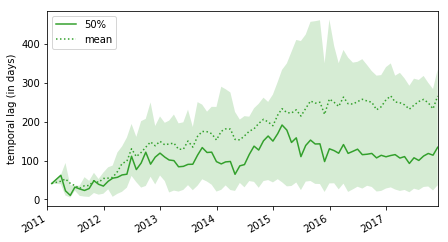

In [17]:
fig, ax = matplotlib.pyplot.subplots()

df_tmp = (
    df_lags_releases
    [lambda d: ~d['Censored']]
    [lambda d: d['TemporalLagAtNextTime'] > pandas.to_timedelta('0D')]
    .groupby(pandas.Grouper(key='NextTime', freq='1M'))
    ['TemporalLagAtNextTime']
    .describe()
    [['mean', '25%', '50%', '75%']]
    .dropna()
    .apply(lambda s: s / pandas.np.timedelta64(1, 'D'), axis=1)
)

df_tmp['50%'].plot(color=PAL_REL, ax=ax)
df_tmp['mean'].plot(color=PAL_REL, style=':', ax=ax)
ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], facecolor=PAL_REL[0], alpha=0.2)

ax.set(
    xlabel='',
    ylabel='temporal lag (in days)',
    xlim=DATE_RANGE,
)
ax.legend(loc='upper left')

savefig(fig, 'temporal_distr_releases_at_nexttime_filtered')
# NOTE: Only packages being updated in given month are considered for that month.

## Inequalities for temporal lag (at release end)

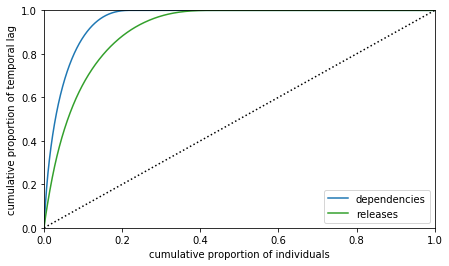

In [18]:
fig, ax = matplotlib.pyplot.subplots()

(
    df_lags
    [lambda d: ~d['Censored']]
    .assign(lag=lambda d: d['TemporalLagAtNextTime'] / pandas.np.timedelta64(1, 'D'))
    .sort_values('lag', ascending=False)
    .assign(n=lambda d: 1 / len(d))
    .assign(p=lambda d: d['lag'] / d['lag'].sum())
    [['n', 'p']]
    .cumsum()
    .set_index('n')
    .rename(columns={'p': 'dependencies'})
    .plot(color=PAL_DEP[0], ax=ax)
)

(
    df_lags_releases
    .assign(lag=lambda d: d['TemporalLagAtNextTime'] / pandas.np.timedelta64(1, 'D'))
    .sort_values('lag', ascending=False)
    .assign(n=lambda d: 1 / len(d))
    .assign(p=lambda d: d['lag'] / d['lag'].sum())
    [['n', 'p']]
    .cumsum()
    .set_index('n')
    .rename(columns={'p': 'releases'})
    .plot(color=PAL_REL[0], ax=ax)
)


ax.set(
    xlabel='cumulative proportion of individuals',
    ylabel='cumulative proportion of temporal lag',
    xlim=(0, 1), 
    ylim=(0, 1),
)

ax.plot([0, 1], [0, 1], 'k:')

savefig(fig, 'temporal_lorenz_releases')

## Temporal lag at release start vs. lag at release end (censored filtered)

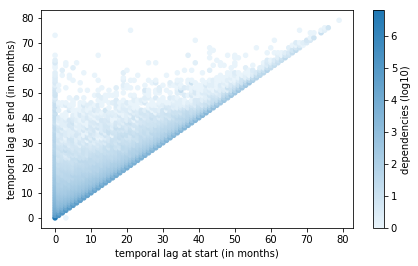

In [19]:
ax = (
    df_lags
    [lambda d: ~d['Censored']]
    .assign(**{
        'lag at start': (lambda d: d['TemporalLagAtTime'] / pandas.np.timedelta64(1, 'D') // 30),
        'lag at end': (lambda d: d['TemporalLagAtNextTime'] / pandas.np.timedelta64(1, 'D') // 30),
        'number': 1,
    })
    [['lag at start', 'lag at end', 'number']]
    .groupby(['lag at start', 'lag at end'], as_index=False)
    .count()
    .assign(number=lambda d: pandas.np.log10(d['number']))
    .rename(columns={'number': 'dependencies (log10)'})
    .plot.scatter('lag at start', 'lag at end', 
                  c='dependencies (log10)', colormap=seaborn.light_palette(PAL_DEP[0], as_cmap=True),
                  sharex=False, # Workaround for a bug in matplotlib/pandas
    )
)

ax.set(
    xlabel='temporal lag at start (in months)', 
    ylabel='temporal lag at end (in months)',
)

savefig(ax.figure, 'temporal_scatter_dependencies_lags')

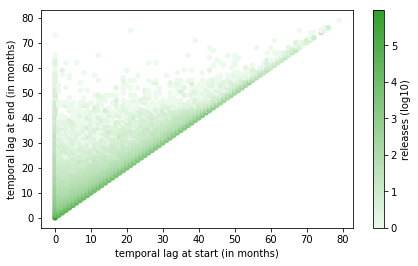

In [20]:
ax = (
    df_lags_releases
    [lambda d: ~d['Censored']]
    .assign(**{
        'lag at start': (lambda d: d['TemporalLagAtTime'] / pandas.np.timedelta64(1, 'D') // 30),
        'lag at end': (lambda d: d['TemporalLagAtNextTime'] / pandas.np.timedelta64(1, 'D') // 30),
        'number': 1,
    })
    [['lag at start', 'lag at end', 'number']]
    .groupby(['lag at start', 'lag at end'], as_index=False)
    .count()
    .assign(number=lambda d: pandas.np.log10(d['number']))
    .rename(columns={'number': 'releases (log10)'})
    .plot.scatter('lag at start', 'lag at end', 
                  c='releases (log10)', colormap=seaborn.light_palette(PAL_REL[0], as_cmap=True),
                  sharex=False, # Workaround for a bug in matplotlib/pandas
    )
)

ax.set(
    xlabel='temporal lag at start (in months)', 
    ylabel='temporal lag at end (in months)',
)

savefig(ax.figure, 'temporal_scatter_releases_lags')

### Prop. with new dependency available, and new missed

### For dependencies

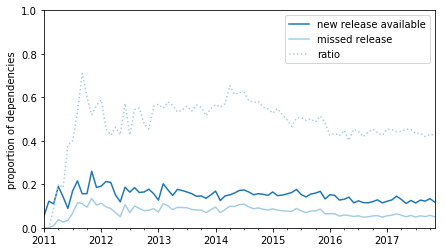

In [21]:
df_tmp = (
    df_lags
    [lambda d: ~d['Censored']]
    .assign(dependencies=1)
    .groupby(pandas.Grouper(key='NextTime', freq='1M'))
    [['dependencies', 'NewAvailable', 'NewMissed']]
    .sum()
    .apply(lambda d: d / d['dependencies'], axis=1)
)

ax = (
    df_tmp
    [['NewAvailable', 'NewMissed']]
    .rename(columns={'NewAvailable': 'new release available', 'NewMissed': 'missed release'})
    .plot(color=PAL_DEP)
)

df_tmp.assign(ratio=lambda d: d['NewMissed'] / d['NewAvailable'])[['ratio']].plot(color=PAL_DEP[1], style=':', ax=ax)

ax.set(
    xlabel='',
    ylabel='proportion of dependencies',
    xlim=DATE_RANGE,
    ylim=(0, 1),
)

savefig(ax.figure, 'temporal_prop_deps_available_missed')

### For releases

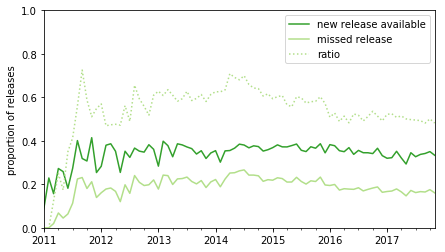

In [22]:
df_tmp = (
    df_lags_releases
    [lambda d: ~d['Censored']]
    .assign(releases=1)
    .groupby(pandas.Grouper(key='NextTime', freq='1M'))
    [['releases', 'NewAvailable', 'NewMissed']]
    .sum()
    .apply(lambda d: d / d['releases'], axis=1)
)

ax = (
    df_tmp
    [['NewAvailable', 'NewMissed']]
    .rename(columns={'NewAvailable': 'new release available', 'NewMissed': 'missed release'})
    .plot(color=PAL_REL)
)

df_tmp.assign(ratio=lambda d: d['NewMissed'] / d['NewAvailable'])[['ratio']].plot(color=PAL_REL[1], style=':', ax=ax)

ax.set(
    xlabel='',
    ylabel='proportion of releases',
    xlim=DATE_RANGE,
    ylim=(0, 1),
)

savefig(ax.figure, 'temporal_prop_rel_available_missed')

### Distribution of delta (0 filtered)

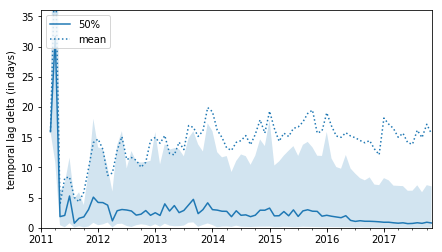

In [23]:
fig, ax = matplotlib.pyplot.subplots()

df_tmp = (
    df_lags
    [lambda d: ~d['Censored']]
    .assign(delta=lambda d: (d['TemporalLagAtNextTime'] - d['TemporalLagAtTime']) / pandas.np.timedelta64(1, 'D'))
    [lambda d: d['delta'] > 0]
    .groupby(pandas.Grouper(key='NextTime', freq='1M'))
    ['delta']
    .describe()
    [['mean', '25%', '50%', '75%']]
)

df_tmp['50%'].plot(color=PAL_DEP, ax=ax)
df_tmp['mean'].plot(color=PAL_DEP, style=':', ax=ax)
ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], facecolor=PAL_DEP[0], alpha=0.2)

ax.set(
    xlabel='',
    ylabel='temporal lag delta (in days)',
    xlim=DATE_RANGE,
    ylim=(0, 36)
)
ax.legend(loc='upper left')

savefig(fig, 'temporal_distr_delta_lag_dependencies')
# NOTE: Only packages being updated in given month are considered for that month.

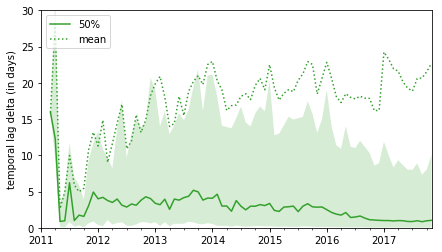

In [45]:
fig, ax = matplotlib.pyplot.subplots()

df_tmp = (
    df_lags_releases
    [lambda d: ~d['Censored']]
    .assign(delta=lambda d: (d['TemporalLagAtNextTime'] - d['TemporalLagAtTime']) / pandas.np.timedelta64(1, 'D'))
    [lambda d: d['delta'] > 0]
    .groupby(pandas.Grouper(key='NextTime', freq='1M'))
    ['delta']
    .describe()
    [['mean', '25%', '50%', '75%']]
)

df_tmp['50%'].plot(color=PAL_REL, ax=ax)
df_tmp['mean'].plot(color=PAL_REL, style=':', ax=ax)
ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], facecolor=PAL_REL[0], alpha=0.2)

ax.set(
    xlabel='',
    ylabel='temporal lag delta (in days)',
    xlim=DATE_RANGE,
    ylim=(0, 30)
)
ax.legend(loc='upper left')

savefig(fig, 'temporal_distr_delta_lag_releases')
# NOTE: Only packages being updated in given month are considered for that month.

### Distribution of delay between releases

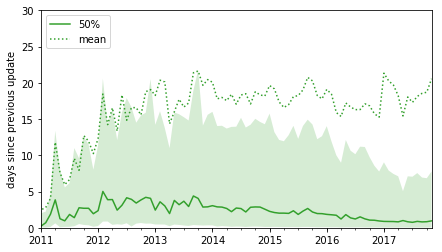

In [25]:
fig, ax = matplotlib.pyplot.subplots()

df_tmp = (
    df_lags_releases
    [lambda d: ~d['Censored']]
    .assign(delta=lambda d: (d['NextTime'] - d['Time']) / pandas.np.timedelta64(1, 'D'))
    .groupby(pandas.Grouper(key='NextTime', freq='1M'))
    ['delta']
    .describe()
    [['mean', '25%', '50%', '75%']]
)

df_tmp['50%'].plot(color=PAL_REL, ax=ax)
df_tmp['mean'].plot(color=PAL_REL, style=':', ax=ax)
ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], facecolor=PAL_REL[0], alpha=0.2)

ax.set(
    xlabel='',
    ylabel='days since previous update',
    xlim=DATE_RANGE,
    ylim=(0, 30)
)
ax.legend(loc='upper left')

savefig(fig, 'temporal_distr_delta_updates')
# NOTE: Only packages being updated in given month are considered for that month.

### Temporal lag delta vs. release age (end - start)

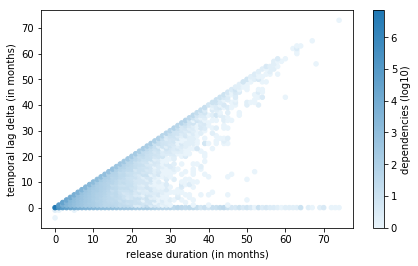

In [26]:
ax = (
    df_lags
    [lambda d: ~d['Censored']]
    .assign(lagdelta=lambda d: (d['TemporalLagAtNextTime'] - d['TemporalLagAtTime']) / pandas.Timedelta('1D') // 30)
    .assign(timedelta=lambda d: (d['NextTime'] - d['Time']) / pandas.Timedelta('1D') // 30)
    .assign(number=1)
    [['lagdelta', 'timedelta', 'number']]
    .groupby(['lagdelta', 'timedelta'], as_index=False)
    .count()
    .assign(number=lambda d: pandas.np.log10(d['number']))
    .rename(columns={'number': 'dependencies (log10)'})
    .plot.scatter('timedelta', 'lagdelta', c='dependencies (log10)', 
                  colormap=seaborn.light_palette(PAL_DEP[0], as_cmap=True),
                  sharex=False, # Workaround for a bug in matplotlib/pandas
    )
)

ax.set(
    xlabel='release duration (in months)',
    ylabel='temporal lag delta (in months)',
)

savefig(ax.figure, 'temporal_scatter_dependencies_lags_vs_duration')

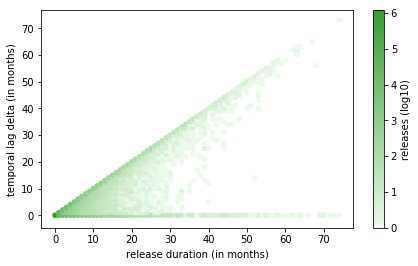

In [27]:
ax = (
    df_lags_releases
    [lambda d: ~d['Censored']]
    .assign(lagdelta=lambda d: (d['TemporalLagAtNextTime'] - d['TemporalLagAtTime']) / pandas.Timedelta('1D') // 30)
    .assign(timedelta=lambda d: (d['NextTime'] - d['Time']) / pandas.Timedelta('1D') // 30)
    .assign(number=1)
    [['lagdelta', 'timedelta', 'number']]
    .groupby(['lagdelta', 'timedelta'], as_index=False)
    .count()
    .assign(number=lambda d: pandas.np.log10(d['number']))
    .rename(columns={'number': 'releases (log10)'})
    .plot.scatter('timedelta', 'lagdelta', c='releases (log10)', 
                  colormap=seaborn.light_palette(PAL_REL[0], as_cmap=True),
                  sharex=False, # Workaround for a bug in matplotlib/pandas
    )
)

ax.set(
    xlabel='release duration (in months)',
    ylabel='temporal lag delta (in months)',
)

savefig(ax.figure, 'temporal_scatter_releases_lags_vs_duration')

## Update type

### Proportion of update types per month

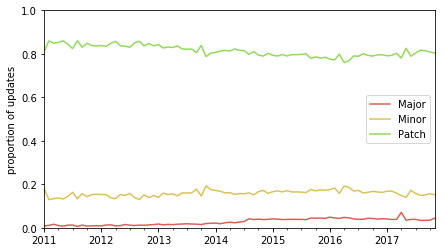

In [28]:
ax = (
    df_releases
    [lambda d: d['ReleaseType'] != 'Initial']
    .assign(Releases=1)
    .groupby([pandas.Grouper(key='ReleaseDate', freq='1M'), 'ReleaseType'])
    [['Releases']]
    .count()
    .unstack(fill_value=0)
    .apply(lambda d: d / d.sum(), axis=1)
    ['Releases']
    [['Major', 'Minor', 'Patch']]
    .plot(color=PAL_UPD)
)

ax.set(
    xlabel='',
    ylabel='proportion of updates',
    xlim=DATE_RANGE,
    ylim=(0, 1)
)

ax.legend(title='')
savefig(ax.figure, 'overview_proportion_update_type')

[(0, 1),
 Text(0,0.5,'proportion of releases'),
 (734138.0, 736663.0),
 Text(0.5,0,'')]

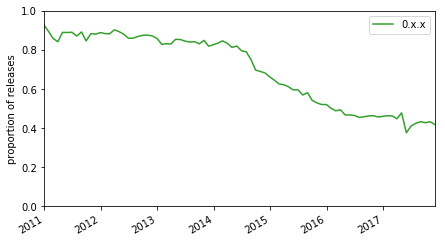

In [29]:
ax = (
    df_releases
    .assign(**{
        '0.x.x': lambda d: d['Release'].str.startswith('0.'),
        '1.x.x': lambda d: d['Release'].str.startswith('1.'),
    })
    .assign(releases=1)
    [['ReleaseDate', '0.x.x', '1.x.x', 'releases']]
    .groupby(pandas.Grouper(key='ReleaseDate', freq='1M'))
    .sum()
    [lambda d: d['releases'] > 0]
    .apply(lambda d: d / d['releases'], axis=1)
    [['0.x.x']]
    .plot(color=PAL_REL)
)

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion of releases',
    ylim=(0, 1),
)

### Delay to update a release of given type

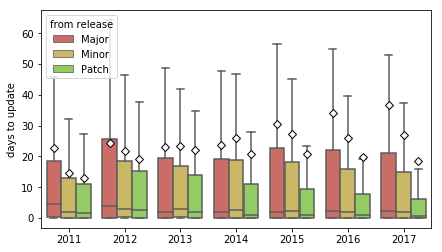

In [30]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxplot(
    x='year', 
    y='delta', 
    hue='PreviousReleaseType',
    data=(
        df_releases
        [lambda d: d['PreviousReleaseType'] != 'Initial']
        .assign(delta=lambda d: (d['ReleaseDate'] - d['PreviousReleaseDate']) / pandas.np.timedelta64(1, 'D'))
        .assign(year=lambda d: d['ReleaseDate'].dt.year)
        [['year', 'delta', 'PreviousReleaseType']]
    ),
    order=range(2011, 2018),
    hue_order=['Major', 'Minor', 'Patch'], 
    palette=PAL_UPD,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)

ax.set(
    xlabel='', 
    ylabel='days to update', 
)

ax.legend(title='from release', loc='upper left')

savefig(fig, 'overview_distr_update_delay_per_source_type')

### Delay to update to a release of given time

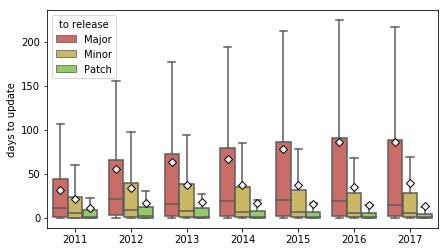

In [31]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxplot(
    x='year', 
    y='delta', 
    hue='NextReleaseType',
    data=(
        df_releases
        [lambda d: d['ReleaseType'] != 'Initial']
        .assign(delta=lambda d: (d['NextReleaseDate'] - d['ReleaseDate']) / pandas.np.timedelta64(1, 'D'))
        .assign(year=lambda d: d['NextReleaseDate'].dt.year)
        [['year', 'delta', 'NextReleaseType']]
    ),
    order=range(2011, 2018),
    hue_order=['Major', 'Minor', 'Patch'], 
    palette=PAL_UPD,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)

ax.set(
    xlabel='', 
    ylabel='days to update', 
)

ax.legend(title='to release', loc='upper left')

savefig(fig, 'overview_distr_update_delay_per_target_type')

### Combinations of current release type / next release type

In [32]:
(
    df_releases
    [lambda d: d['ReleaseType'] != 'Initial']
    [lambda d: d['NextReleaseType'] != 'Initial']
    .assign(Delay=lambda d: (d['NextReleaseDate'] - d['ReleaseDate']) / pandas.to_timedelta('1D'))
    .assign(Releases=1)
    [['ReleaseType', 'NextReleaseType', 'Delay', 'Releases']]
    .groupby(['ReleaseType', 'NextReleaseType'])
    .agg({
        'Releases': 'count',
        'Delay': 'mean',
        }
    )
    .sort_index()
)

Releases      Delay
ReleaseType NextReleaseType                     
Major       Major               11122  68.150992
            Minor               22739  44.054568
            Patch               62519  23.211946
Minor       Major               24662  76.820245
            Minor              170337  30.805585
            Patch              269242  18.478806
Patch       Major               64494  87.697407
            Minor              276834  40.993464
            Patch             1965977  14.271008

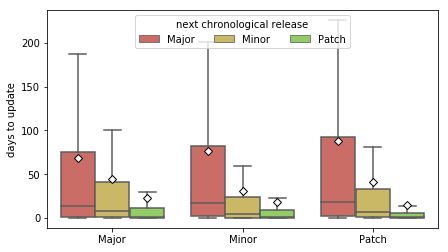

In [59]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxplot(
    x='ReleaseType',
    y='Delay',
    hue='NextReleaseType',
    order=['Major', 'Minor', 'Patch'],
    hue_order=['Major', 'Minor', 'Patch'],
    data = (
        df_releases
        [lambda d: d['ReleaseType'] != 'Initial']
        [lambda d: d['NextReleaseType'] != 'Initial']
        .assign(Delay=lambda d: (d['NextReleaseDate'] - d['ReleaseDate']) / pandas.to_timedelta('1D'))
        [['ReleaseType', 'NextReleaseType', 'Delay']]
    ),
    palette=PAL_UPD,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)

ax.set(
    xlabel='',
    ylabel='days to update',
)

ax.legend(title='next chronological release', loc='upper center', ncol=3)
savefig(fig, 'overview_distr_update_delay_combinations')

### Temporal lag at release start, per release type

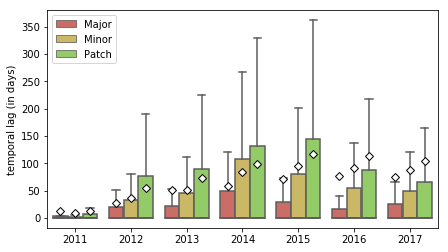

In [52]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxplot(
    x='year', 
    y='lag', 
    hue='ReleaseType',
    data=(
        df_lags_releases
        [lambda d: d['ReleaseType'] != 'Initial']
        [lambda d: ~d['Censored']]
        .assign(lag=lambda d: d['TemporalLagAtTime'] / pandas.np.timedelta64(1, 'D'))
        .assign(year=lambda d: d['Time'].dt.year)
        [['year', 'lag', 'ReleaseType']]
    ),
    order=range(2011, 2018),
    hue_order=['Major', 'Minor', 'Patch'], 
    palette=PAL_UPD,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)

ax.set(
    xlabel='', 
    ylabel='temporal lag (in days)', 
)

ax.legend(title='', loc='upper left')

savefig(fig, 'temporal_distr_lag_at_time_per_update_type')

### Temporal lag at release end, per release type

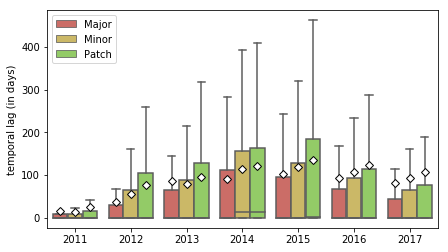

In [35]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxplot(
    x='year', 
    y='lag', 
    hue='ReleaseType',
    data=(
        df_lags_releases
        [lambda d: d['ReleaseType'] != 'Initial']
        [lambda d: ~d['Censored']]
        .assign(lag=lambda d: d['TemporalLagAtNextTime'] / pandas.np.timedelta64(1, 'D'))
        .assign(year=lambda d: d['Time'].dt.year)
        [['year', 'lag', 'ReleaseType']]
    ),
    order=range(2011, 2018),
    hue_order=['Major', 'Minor', 'Patch'], 
    palette=PAL_UPD,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)

ax.set(
    xlabel='', 
    ylabel='temporal lag (in days)', 
)

ax.legend(title='', loc='upper left')

savefig(fig, 'temporal_distr_lag_at_next_time_per_update_type')

## Variation in temporal lag

### Variation from release (at end) to next release (at start)

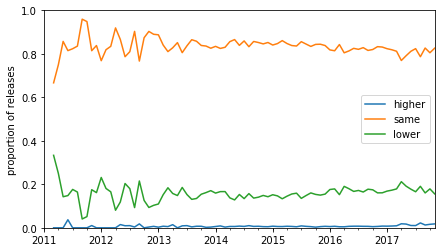

In [36]:
df_tmp = (
    df_lags_releases
    .dropna(subset=['PreviousReleaseType'])
    [lambda d: d['PreviousTemporalLagAtNextTime'] > pandas.to_timedelta('0D')]
    .assign(delta=lambda d: (d['TemporalLagAtTime'] - d['PreviousTemporalLagAtNextTime']) / pandas.to_timedelta('1D'))
    .assign(
        releases=1,
        higher=lambda d: (d['delta'] > 0).astype(int),
        same=lambda d: (d['delta'] == 0).astype(int),
        lower=lambda d: (d['delta'] < 0).astype(int),
        removed=lambda d: ((d['delta'] < 0) & (d['TemporalLagAtTime'] == pandas.to_timedelta('0D'))).astype(int)
    )
    [['Time', 'releases', 'higher', 'same', 'lower', 'removed']]
    .groupby(pandas.Grouper(key='Time', freq='1M'))
    .sum()
    .apply(lambda d: d / d['releases'], axis=1)
)

ax = df_tmp[['higher', 'same', 'lower']].plot(color=PAL_VAR)

ax.set(
    xlabel='',
    ylabel='proportion of releases',
    xlim=DATE_RANGE,
    ylim=(0, 1)
)

savefig(ax.figure, 'temporal_variation_proportion')

### By update type (ie. next release type)

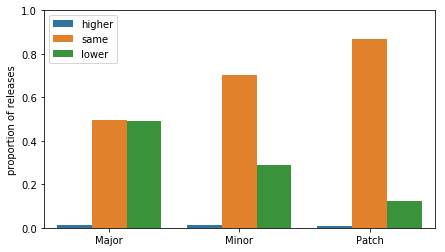

In [37]:
fig, ax = matplotlib.pyplot.subplots()

df_tmp = (
    df_lags_releases
    [lambda d: (~d['Censored']) & (d['ReleaseType'] != 'Initial')]
    .dropna(subset=['PreviousReleaseType'])
    [lambda d: d['PreviousTemporalLagAtNextTime'] > pandas.to_timedelta('0D')]
    .assign(delta=lambda d: (d['TemporalLagAtTime'] - d['PreviousTemporalLagAtNextTime']) / pandas.to_timedelta('1D'))
    .assign(
        releases=1,
        higher=lambda d: (d['delta'] > 0).astype(int),
        same=lambda d: (d['delta'] == 0).astype(int),
        lower=lambda d: (d['delta'] < 0).astype(int),
        removed=lambda d: ((d['delta'] < 0) & (d['TemporalLagAtTime'] == pandas.to_timedelta('0D'))).astype(int)
    )
    [['ReleaseType', 'releases', 'higher', 'same', 'lower', 'removed']]
    .groupby('ReleaseType')
    .sum()
    .apply(lambda d: d / d['releases'], axis=1)
    .reset_index()
)


seaborn.barplot(
    x='ReleaseType',
    y='proportion',
    hue='variation',
    data=pandas.melt(
        df_tmp, 
        id_vars=['ReleaseType'], 
        value_vars=['higher', 'same', 'lower'], 
        var_name='variation', 
        value_name='proportion'
    ),
    order=['Major', 'Minor', 'Patch'],
    hue_order=['higher', 'same', 'lower'], 
    palette=PAL_VAR, 
    ax=ax
)

ax.set(
    xlabel='', 
    ylabel='proportion of releases',
    ylim=(0, 1),
)

ax.legend(title='')

savefig(ax.figure, 'temporal_variation_proportion_per_type')

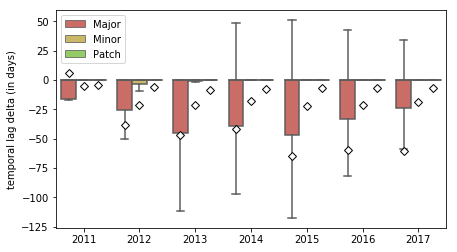

In [38]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxplot(
    x='year', 
    y='delta', 
    hue='ReleaseType',
    data=(
        df_lags_releases
        [lambda d: (~d['Censored']) & (d['ReleaseType'] != 'Initial')]
        .dropna(subset=['PreviousReleaseType'])
        [lambda d: d['PreviousTemporalLagAtNextTime'] > pandas.to_timedelta('0D')]
        .assign(delta=lambda d: (d['TemporalLagAtTime'] - d['PreviousTemporalLagAtNextTime']) / pandas.to_timedelta('1D'))
        .assign(year=lambda d: d['Time'].dt.year)
        [['year', 'delta', 'ReleaseType']]
    ),
    order=range(2011, 2018),
    hue_order=['Major', 'Minor', 'Patch'], 
    palette=PAL_UPD,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)

ax.set(
    xlabel='', 
    ylabel='temporal lag delta (in days)', 
)

ax.legend(title='', loc='upper left')

savefig(fig, 'temporal_variation_delta_per_type')

# Version lag

## Proportion of releases missing or adopting Major, minor and patch

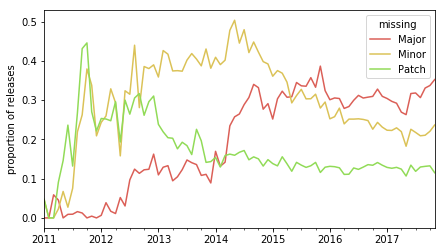

In [53]:
df_tmp = (
    df_lags_releases
    [lambda d: ~d['Censored']]
    # [lambda d: d['NewAvailable']]
    .assign(
        releases=1,
        Major=lambda d: d['MLagAtNextTime'] > 0, 
        Minor=lambda d: d['mLagAtNextTime'] > 0,
        Patch=lambda d: d['pLagAtNextTime'] > 0,
    )
    [['NextTime', 'releases', 'Major', 'Minor', 'Patch']]
    .groupby(pandas.Grouper(key='NextTime', freq='1M'))
    .sum()
    .apply(lambda d: d / d['releases'], axis=1)
    [['Major', 'Minor', 'Patch']]
)

ax = df_tmp.plot(color=PAL_UPD)

ax.set(
    xlabel='',
    ylabel='proportion of releases',
    xlim=DATE_RANGE,
    #ylim=(0, 1)
)
ax.legend(title='missing')

savefig(ax.figure, 'version_prop_missing_major_minor_patch')

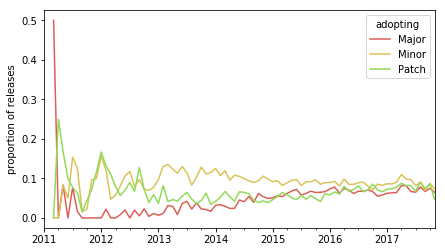

In [40]:
df_tmp = (
    df_lags_releases
    [lambda d: ~d['Censored']]
    [lambda d: d['PreviousReleaseType'] != 'Initial']
    [lambda d: (d['PreviousMLagAtNextTime'] + d['PreviousmLagAtNextTime'] + d['PreviouspLagAtNextTime']) > 0]
    .assign(
        releases=1, 
        Major=lambda d: d['MLagAtTime'] < d['PreviousMLagAtNextTime'],
        Minor=lambda d: d['mLagAtTime'] < d['PreviousmLagAtNextTime'],
        Patch=lambda d: d['pLagAtTime'] < d['PreviouspLagAtNextTime'],
    )
    [['NextTime', 'releases', 'Major', 'Minor', 'Patch']]
    .groupby(pandas.Grouper(key='NextTime', freq='1M'))
    .sum()
    .apply(lambda d: d / d['releases'], axis=1)
    [['Major', 'Minor', 'Patch']]
)


ax = df_tmp.plot(color=PAL_UPD)

ax.set(
    xlabel='',
    ylabel='proportion of releases',
    xlim=DATE_RANGE,
    #ylim=(0, 1)
)
ax.legend(title='adopting')

savefig(ax.figure, 'version_prop_adopting_major_minor_patch')

## Proportion of releases missing Major, minor and patch, by update type

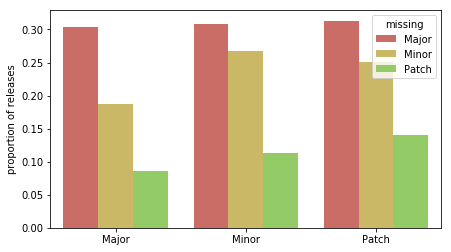

In [41]:
fig, ax = matplotlib.pyplot.subplots()

df_tmp = (
    df_lags_releases
    [lambda d: ~d['Censored']]
    # [lambda d: d['NewAvailable']]
    [lambda d: d['ReleaseType'] != 'Initial']
    .assign(
        releases=1,
        Major=lambda d: d['MLagAtNextTime'] > 0, 
        Minor=lambda d: d['mLagAtNextTime'] > 0,
        Patch=lambda d: d['pLagAtNextTime'] > 0,
    )
    [['ReleaseType', 'releases', 'Major', 'Minor', 'Patch']]
    .groupby('ReleaseType')
    .sum()
    .apply(lambda d: d / d['releases'], axis=1)
    .reset_index()
)


seaborn.barplot(
    x='ReleaseType',
    y='proportion',
    hue='missing',
    data=pandas.melt(
        df_tmp, 
        id_vars=['ReleaseType'], 
        value_vars=['Major', 'Minor', 'Patch'], 
        var_name='missing', 
        value_name='proportion'
    ),
    order=['Major', 'Minor', 'Patch'],
    hue_order=['Major', 'Minor', 'Patch'],
    palette=PAL_UPD, 
    ax=ax
)

ax.set(
    xlabel='',
    ylabel='proportion of releases',
)

savefig(fig, 'version_prop_missing_per_type')

### Proportion of releases, by type, that adopted a new version of a dependency, by type of new version

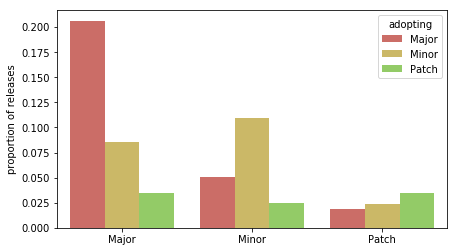

In [56]:
df_tmp = (
    df_lags_releases
    [lambda d: ~d['Censored']]
    [lambda d: d['PreviousReleaseType'] != 'Initial']
    #[lambda d: (d['PreviousMLagAtNextTime'] + d['PreviousmLagAtNextTime'] + d['PreviouspLagAtNextTime']) > 0]
    .assign(
        Releases=1, 
        Major=lambda d: d['MLagAtTime'] < d['PreviousMLagAtNextTime'],
        Minor=lambda d: d['mLagAtTime'] < d['PreviousmLagAtNextTime'],
        Patch=lambda d: d['pLagAtTime'] < d['PreviouspLagAtNextTime'],
    )
    [['ReleaseType', 'Releases', 'Major', 'Minor', 'Patch']]
    .groupby('ReleaseType')
    .sum()
    .apply(lambda d: d / d['Releases'], axis=1)
    .reset_index()
)

ax = seaborn.barplot(
    x='ReleaseType',
    y='proportion',
    hue='adopting',
    data=pandas.melt(
        df_tmp, 
        id_vars=['ReleaseType'], 
        value_vars=['Major', 'Minor', 'Patch'], 
        var_name='adopting', 
        value_name='proportion'
    ),
    order=['Major', 'Minor', 'Patch'],
    hue_order=['Major', 'Minor', 'Patch'],
    palette=PAL_UPD, 
)

ax.set(
    xlabel='',
    ylabel='proportion of releases',
)

savefig(ax.figure, 'version_prop_adopting_per_type')